<a href="https://colab.research.google.com/github/jamal94sm/TIHM/blob/main/TIHM_data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install joypy

**Clone Github repo and set working directory path**

In [ ]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization.git
%cd /content/TIHM-Dataset-Visualization

Cloning into 'TIHM-Dataset-Visualization'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 47 (delta 19), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 13.25 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/TIHM-Dataset-Visualization


**Load packages**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
from joypy import joyplot
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from joypy import joyplot
from utils import *

%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

In [ ]:
def concat_slist(slist):
    s = ''
    for vs in slist:
        s+= str(vs)+','
    return s

def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['date'] = pd.to_datetime(df[tcol].dt.date)
    return df

def transform_category_to_counts(df,col,keys):
    tmp = df.groupby([col]+ keys).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index=keys)
    tmp = tmp.drop(tmp.index[tmp.values.sum(axis=1)==0],axis=0).reset_index()
    return tmp


def get_personal_df(df,pid):
    if not 'patient_id' in df.columns:
        df = df.reset_index()
    tmp = df.loc[df.patient_id==pid].drop('patient_id',axis=1)

    return tmp



def min_max_perpatient(df,skip=[]):
    for pid in df.patient_id.unique():
        ptmp = df.loc[df.patient_id==pid]
        for c in ptmp.columns:
            if 'int' in str(ptmp[c].dtype) or 'float' in str(ptmp[c].dtype):
                if ptmp[c].notna().sum() > 0 and c not in skip:
                    min_v = np.nanmin(ptmp[c].values)
                    max_v = np.nanmax(ptmp[c].values)
                    if max_v > min_v:
                        df.loc[df.patient_id==pid,c] = (ptmp[c].values-min_v)/(max_v-min_v)
                    elif max_v!=0:
                        df.loc[df.patient_id==pid,c] = 0.5 #only one record
    return df


def gen_summary(df):

  sm = pd.DataFrame(columns=['Value Type','Value Number','Description'])

  for stc in df.columns:
      sm.loc[stc,'Value Type'] = str(type(df[stc].dtype)).split('.')[-1].split('\'')[0].lower()
      if 'categorical' in sm.loc[stc,'Value Type'] or 'object' in sm.loc[stc,'Value Type']:
          vset = set(df[stc].values)
          sm.loc[stc, 'Value Number'] = len(vset)
          dl = len(vset) if 5 > len(vset) else 5
          if 'id' in stc:
              sm.loc[stc,'Description'] = 'hash code'
          else:
              sm.loc[stc,'Description'] = concat_slist(list(vset)[:dl])
      elif 'datetime' in sm.loc[stc,'Value Type'].lower():
          sm.loc[stc,'Description'] = 'from '+ str(df[stc].min()) + ' to ' + str(str(df[stc].max()))
      elif 'float' in sm.loc[stc,'Value Type'] or 'int' in sm.loc[stc,'Value Type']:
          sm.loc[stc,'Description'] = 'min: ' + str(df[stc].min()) + ', max: ' + str(str(df[stc].max()))
      elif 'bool' in sm.loc[stc,'Value Type']:
          sm.loc[stc, 'Value Number'] = 2
          sm.loc[stc,'Description'] = 'True or False'

  return sm

#from .data_utils import *

def save_fig(fname,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,fname),bbox_inches='tight')

def save_personal_fig(pid,fname,save_path):
    save_path = os.path.join(save_path,pid)
    save_fig(fname,save_path)

def add_personal_label_markers(labels_df,pid,ax,max_v,add_marker=True,marker_color='orchid',
                               add_lgd=True,lgd_loc=[1.01,0.75],min_v=0):

    lbs = labels_df.loc[labels_df.patient_id==pid]
    lmarkers = ['*','s','^','o','P','p','h','D']
    lax, lax_lgd = [], []

    if add_marker:
        for i,l in enumerate(lbs.type.values.categories):
            ltmp = lbs.loc[lbs.type==l]
            if len(ltmp)>0:
                ll = ax.plot(ltmp['date'],[max_v]*len(ltmp),lmarkers[i],color=marker_color)
                lax.append(ll[0])
                lax_lgd.append(l)

    for i in range(len(lbs)):
        ax.plot([lbs.date.values[i],lbs.date.values[i]],[min_v,max_v],'--',color='C7')

    if add_lgd:
        lb_patch = mpatches.Patch(color='orchid')
        lbl_lgd = ax.legend([lb_patch]+lax, ['Alerts']+lax_lgd, loc=lgd_loc,fontsize=9)
        ax.add_artist(lbl_lgd)
        return None, None
    else:
        return lax,lax_lgd


def dsample_xticks(N,m=10):
    gap = N/m
    idx = [int(i*gap) for i in range(m)]
    if N%m>0:
        idx+=[N-1]
    return idx


def draw_day_ridge_plot(day_df,ax=None,xticks=None):
    x_range = np.arange(day_df.shape[0])
    f, axes = joyplot(day_df,kind="values",x_range=x_range,overlap = 0.5, colormap=cm.Blues_r,
                      fade=True,figsize=[10,4],linewidth=0.25,alpha=0.6,ax=ax)

    if xticks is None:
        idx = dsample_xticks(day_df.shape[0],m=10)

        axes[-1].set_xticks(x_range[idx],labels=day_df.index[idx])
    else:
        axes[-1].set_xticks(xticks[0],xticks[1])
    return


def vis_day_counts_ridge_plot(raw_df,col,title,fname,save_path='./figs/',drop_list=None,
                              transform=False,ax=None,xticks=None):
    if transform:
        tmp = raw_df.groupby([col, 'date']).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index='date')
    else:
        tmp = raw_df.groupby('date')[act_df.select_dtypes(include=['number']).columns].sum()

    if drop_list is not None:
        tmp = tmp.drop(drop_list,axis=1)
    draw_day_ridge_plot(tmp,ax=ax,xticks=xticks)
    plt.title(title)
    save_fig(fname,save_path=save_path)


def get_personal_sleep_day_df(sleep_df,pid):

    sleep_states = ['AWAKE', 'LIGHT', 'DEEP', 'REM']
    sleep_df = sleep_df.set_index('date')
    sdtmp = get_personal_df(sleep_df,pid).loc[:,sleep_states]#get_personal_agg_info_df(sleep_df,pid,cols=sleep_states,keys=['date'],agg_fn='sum')
    pdtmp = get_personal_df(sleep_df,pid).loc[:,['heart_rate','respiratory_rate']] #get_personal_agg_info_df(sleep_df,pid,cols=['heart_rate','respiratory_rate'],keys=['date'],agg_fn='max')

    return sdtmp,pdtmp

def vis_personal_aligned_multiview_day_plot(phys_df,pgrps,pid,save_path,sleep_df=None,act_df=None,
                                            labels_df=None,ftype='svg',xticks=None):

    sns.set_style("whitegrid",{'axes.grid': True,'grid.linestyle': '--', 'axes.spines.left':False,
                            'axes.spines.right':False,'axes.spines.top':False})
    cmap = sns.color_palette('colorblind')#cm.get_cmap('tab10').colors

    #sleep_states = sleep_df['state'].unique()
    if sleep_df is not None:
        sdtmp, _ = get_personal_sleep_day_df(sleep_df,pid)
    if act_df is not None:
        adtmp = transform_category_to_counts(act_df,col='location_name',keys=['patient_id','date'])

        adtmp = get_personal_df(adtmp,pid)
        adtmp = adtmp.set_index('date')
        adtmp['total'] = adtmp.sum(axis=1)

    if sleep_df is not None and len(sdtmp) > 0 and act_df is not None:
        adtmp,sdtmp = align_dates(adtmp,sdtmp)



    pdtmp = get_personal_df(phys_df,pid)
    #pdtmp = pdtmp.set_index('date')
    if act_df is not None:
        pdtmp.drop(pdtmp.loc[(pdtmp.date<adtmp.index.values.min())|(pdtmp.date>adtmp.index.values.max())].index,axis=0,inplace=True)
    pv = pd.pivot_table(pdtmp, values='value', index=['date'],
                    columns=['device_type'])
    pv = pv.rename(columns={'Skin Temperature':'Skin temperature','Body Temperature':'Body temperature'})
    pvs = []
    for i,pgrp in enumerate(pgrps.values()):
        pgrp = list(set(pgrp) & set(pv.columns))
        if len(pgrp)>0:
            pvi = pv[pgrp]
            pvi = pvi.drop(pvi.columns[pvi.values.sum(axis=0)==0],axis=1)
            pvs.append(pvi)



    nr = len(pvs)+1 if act_df is not None else len(pvs)
    f, axs = plt.subplots(nr, 1,gridspec_kw={'height_ratios': [1]*nr},figsize=[10,3*nr],sharex=True)

    ci = 0
    axi = 0
    if act_df is not None:
        aax = axs[0].fill_between(x=adtmp.index,y1=np.zeros(adtmp.shape[0]),y2=adtmp['total'].values,alpha=0.4,color=cmap[ci])
        handles = [aax]
        max_v = adtmp.values.max()
        lgd = ['Acitivity counts']
        ci+=1
        if sleep_df is not None and len(sdtmp) > 0:
            sdtmp['total'] = sdtmp.sum(axis=1)
            sax = axs[0].fill_between(x=sdtmp.index,y1=np.zeros(sdtmp.shape[0]),y2=sdtmp['total'].values,alpha=0.4,color=cmap[ci])
            ci+=1
            handles.append(sax)
            max_v = max(max_v,sdtmp.values.max())
            lgd.append('Sleep duration (minutes)')

        axs[0].tick_params(labelbottom=True)
        axi += 1

    if labels_df is not None:
        if act_df is not None:
            labels_df = labels_df.drop(labels_df.loc[(labels_df.date<adtmp.index.values.min())|(labels_df.date>adtmp.index.values.max())].index,axis=0)
        labels_df = labels_df.loc[labels_df['patient_id']==pid]
        if len(labels_df)==0:
            labels_df = None

    if labels_df is not None and axi >0:
        add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)
        axs[0].legend(handles,lgd,loc=[1.01,0.1])



    for i,pvi in enumerate(pvs):

        lls = axs[i+axi].plot(pvi.index,pvi.values,'.-')
        for l in lls:
            l.set_color(cmap[ci])
            ci+=1

        axs[i+axi].tick_params(labelbottom=True)

        max_v = pvi.fillna(0).values.max()*1.1
        min_v = pvi.fillna(999).values.min()*0.9

        if labels_df is not None:
            if i+axi>0:
                add_personal_label_markers(pid=pid,ax=axs[i+axi],max_v=max_v,
                                       labels_df=labels_df,add_marker=True,add_lgd=False,min_v=min_v)
            else:
                add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)

        axs[i+axi].legend(pvi.columns,loc=[1.01,0.1])

    if xticks is None:
        if act_df is None:
            xidx = dsample_xticks((pvs[0].index[-1]-pvs[0].index[0]).days,m=8)
            xticks = [pvs[0].index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        else:
            xidx = dsample_xticks((adtmp.index[-1]-adtmp.index[0]).days,m=8)
            xticks = [adtmp.index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        axs[0].set_xticks(xticks,labels=xticks)

    else:
        axs[0].set_xticks(xticks,labels=xticks)

    #axs[0].set_title('Patient '+str(pid)+' aligned multiview day trend')
    save_personal_fig(pid=pid,fname='personal_multiview_day_plot.'+ftype,save_path=save_path)





**Set Data and Fig folders paths**

In [ ]:
## Please change the path with the path of your dataset
DPATH = './Data'
SAVE_PATH = './Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)



**Load and preprocess dataset files**

In [ ]:
## Read all tables into data_dict and generate table summaries
files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)

    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
        df['date'] = pd.to_datetime(df['timestamp'].dt.date)

    fname = f.split('.')[0]
    data_dict[fname] = df
    summaries[fname] = gen_summary(df)

for name, data in data_dict.items():
  print(f'__________________{name} data:\n ________________')
  print(f'{data.head()} \n summary: \n {summaries[name]}')
  print('________________________________________')

Activity.csv
Sleep.csv
Labels.csv
Demographics.csv
Physiology.csv
__________________Activity data:
 ________________
  patient_id location_name           timestamp       date
0      0697d   Fridge Door 2019-06-28 13:03:29 2019-06-28
1      0697d       Kitchen 2019-06-28 13:11:44 2019-06-28
2      0697d    Front Door 2019-06-28 13:13:50 2019-06-28
3      0697d       Bedroom 2019-06-28 13:13:53 2019-06-28
4      0697d   Fridge Door 2019-06-28 13:14:09 2019-06-28 
 summary: 
                      Value Type Value Number  \
patient_id     categoricaldtype           56   
location_name  categoricaldtype            8   
timestamp       datetime64dtype          NaN   
date            datetime64dtype          NaN   

                                                   Description  
patient_id                                           hash code  
location_name    Back Door,Bedroom,Fridge Door,Lounge,Kitchen,  
timestamp      from 2019-04-01 00:05:46 to 2019-06-30 23:59:32  
date           from 2

In [ ]:
physio_df = data_dict['Physiology'].copy()
label_df = data_dict['Labels'].copy()

In [ ]:
physio_label_df = pd.merge(physio_df,label_df,on=['timestamp','date','patient_id'],how='outer')

In [ ]:
physio_label_df = physio_label_df.sort_values(['patient_id','timestamp'])


In [ ]:
physio_label_df

,patient_id,timestamp,device_type,value,unit,date,type
17571,0697d,2019-06-28 13:30:43,NaN,NaN,NaN,2019-06-28,Blood pressure
17572,0697d,2019-06-28 13:30:43,NaN,NaN,NaN,2019-06-28,Pulse
17574,0697d,2019-06-28 13:42:09,Body Temperature,36.072,Cel,2019-06-28,NaN
17575,0697d,2019-06-28 13:42:44,Body Temperature,35.831,Cel,2019-06-28,NaN
17576,0697d,2019-06-28 13:43:40,Body Temperature,35.831,Cel,2019-06-28,NaN
...,...,...,...,...,...,...,...
17651,fd100,2019-06-28 21:09:27,Heart rate,61.000,beats/min,2019-06-28,NaN
17652,fd100,2019-06-28 21:32:19,Body Temperature,36.879,Cel,2019-06-28,NaN
17653,fd100,2019-06-28 21:32:46,Body Temperature,36.879,Cel,2019-06-28,NaN
17982,fd100,2019-06-29 21:05:11,Body Temperature,36.240,Cel,2019-06-29,NaN


In [ ]:
blood_pressure_dates = physio_label_df.loc[physio_label_df['type']=='Blood pressure'].date.unique()
df = pd.pivot_table(physio_label_df,values='value',columns='device_type',index='timestamp')[['Systolic blood pressure','Diastolic blood pressure']].copy()
df.loc[~df.isna().apply(lambda x: all(x), axis=1)]
df['Pressure Difference'] = df['Systolic blood pressure'] - df['Diastolic blood pressure']
df[~df.isna().apply(lambda x: all(x), axis=1)]

device_type,Systolic blood pressure,Diastolic blood pressure,Pressure Difference
timestamp,,,
2019-04-01 08:57:31,142.0,83.0,59.0
2019-04-04 09:50:12,174.0,99.0,75.0
2019-04-04 10:35:53,149.0,75.0,74.0
2019-04-04 17:02:31,152.0,80.0,72.0
2019-04-05 10:35:20,128.0,71.0,57.0
...,...,...,...
2019-06-30 22:44:56,187.0,89.0,98.0
2019-06-30 22:46:34,180.0,93.0,87.0
2019-06-30 22:48:01,181.0,92.0,89.0


In [ ]:
physio_label_df.loc[physio_label_df['type']=='Agitation']

,patient_id,timestamp,device_type,value,unit,date,type
12753,099bc,2019-06-10 12:01:04,NaN,NaN,NaN,2019-06-10,Agitation
8873,0cda9,2019-05-28 12:01:04,NaN,NaN,NaN,2019-05-28,Agitation
7446,0d5ef,2019-05-23 12:01:46,NaN,NaN,NaN,2019-05-23,Agitation
7777,0d5ef,2019-05-24 12:02:08,NaN,NaN,NaN,2019-05-24,Agitation
8031,0d5ef,2019-05-25 12:01:29,NaN,NaN,NaN,2019-05-25,Agitation
...,...,...,...,...,...,...,...
3009,ec812,2019-05-06 12:00:43,NaN,NaN,NaN,2019-05-06,Agitation
4116,ec812,2019-05-11 12:01:19,NaN,NaN,NaN,2019-05-11,Agitation
11965,ec812,2019-06-07 18:01:26,NaN,NaN,NaN,2019-06-07,Agitation
12676,ec812,2019-06-10 09:50:00,NaN,NaN,NaN,2019-06-10,Agitation


In [ ]:
from datetime import timedelta
pid = '099bc'
date = pd.to_datetime('2019-06-10')
df_p = get_personal_df(physio_label_df,pid)
df_filtered = df_p.loc[df_p['date'].isin([date-timedelta(days=2),
                                       date-timedelta(days=1),date])]
df_filtered

,timestamp,device_type,value,unit,date,type
12038,2019-06-08 08:38:20,Body Temperature,36.871,Cel,2019-06-08,NaN
12039,2019-06-08 08:38:52,Body Temperature,36.966,Cel,2019-06-08,NaN
12040,2019-06-08 08:39:05,Body Temperature,36.096,Cel,2019-06-08,NaN
12044,2019-06-08 08:39:20,Body Temperature,36.966,Cel,2019-06-08,NaN
12048,2019-06-08 08:42:34,Body weight,52.400,kg,2019-06-08,NaN
12049,2019-06-08 08:42:34,Total body water,52.300,%,2019-06-08,NaN
12050,2019-06-08 08:42:34,O/E - muscle mass,37.400,kg,2019-06-08,NaN
12306,2019-06-09 08:22:48,Systolic blood pressure,142.000,mm[Hg],2019-06-09,NaN
12307,2019-06-09 08:22:48,Diastolic blood pressure,80.000,mm[Hg],2019-06-09,NaN
12308,2019-06-09 08:22:48,Heart rate,79.000,beats/min,2019-06-09,NaN


In [ ]:
agitation_sample_ts = pd.to_datetime('2019-05-06 00:36:37')
descretize(agitation_sample_ts,(agitation_sample_ts.hour*60+agitation_sample_ts.minute)/60,interval)

36


Timestamp('2019-05-06 00:36:00')

In [ ]:
variation_count

,6H_interval,match,only_interval,Agitation
0,2019-04-23 06:00:00,83.0,to 6:0,0.0
1,2019-04-23 12:00:00,110.0,to 12:0,0.0
2,2019-04-23 18:00:00,67.0,to 18:0,0.0
3,2019-04-24 00:00:00,8.0,to 0:0,0.0
4,2019-04-24 06:00:00,157.0,to 6:0,0.0
...,...,...,...,...
264,2019-06-29 18:00:00,84.0,to 18:0,0.0
265,2019-06-30 00:00:00,7.0,to 0:0,0.0
266,2019-06-30 06:00:00,130.0,to 6:0,0.0
267,2019-06-30 12:00:00,137.0,to 12:0,0.0


Agitation Plot

In [ ]:
from datetime import timedelta

def descretize(timestamp, reference_hour=4, interval=6):
    # Create the list of reference hours in a day
    reference_hours = [(reference_hour + i * interval) % 24 for i in range(24 // interval)]
    #print(reference_hours)
    # Extract the hour from the given timestamp
    current_hour = timestamp.hour+timestamp.minute/60
    flag = 0
    # Find the largest reference hour less than or equal to the current hour
    arg_max = [h for h in reference_hours if h <= current_hour]
    if len(arg_max)>0 :
      floored_time = max(arg_max)
    else:
      floored_time = max(reference_hours)
      flag = 1
    # Convert to hours and minutes

    hour = int(floored_time)  # Integer part represents hours
    minute = int((floored_time - hour) * 60)  # Decimal part converted to minutes
    #print(minute)

    # Update the timestamp to the floored hour
    if flag:
      floored_time = timestamp.replace(hour=hour, minute=minute, second=0, microsecond=0) - timedelta(days=1)
    else:
      floored_time = timestamp.replace(hour=hour, minute=minute, second=0, microsecond=0)


    return floored_time
ag_flag = 1
sample_n = 0
ag_patients = data_dict['Labels']['patient_id'].loc[data_dict['Labels']['type']=='Agitation'].unique()
pid = ag_patients[5]
activity_df = get_personal_df(data_dict['Activity'].copy(),pid)
physio_df = get_personal_df(data_dict['Physiology'].copy(),pid)
label_df = get_personal_df(data_dict['Labels'].copy(),pid)
ph_df = pd.pivot_table(physio_df,values='value',columns='device_type',index=['timestamp','date']).reset_index()
label_df['Agitation'] = label_df['type'].copy().apply(lambda x: 1 if x=='Agitation' else 0)
merge_df = pd.merge(ph_df,activity_df,on=['timestamp','date'],how='outer')
merge_df = pd.merge(merge_df,label_df,on=['timestamp','date'],how='outer')

agitation_sample_ts = pd.Timestamp(merge_df['timestamp'].loc[merge_df['Agitation']==ag_flag].values[sample_n])
interval = 6 # Hours

# Filter merge_df based on the timestamp range
merge_df[f'{interval}H_interval'] = \
merge_df['timestamp'].apply(lambda x: descretize(x,(agitation_sample_ts.hour*60+agitation_sample_ts.minute)/60,interval))

df = merge_df.loc[~merge_df['location_name'].isna()].copy().reset_index()
unique_loc = df['location_name'].unique()
df['loc_int'] = df['location_name'].replace(unique_loc,np.arange(len(unique_loc)))
loc_shift = pd.concat([pd.DataFrame([np.NaN], columns=['loc_int']), df[['loc_int']]]).reset_index(drop=True)
df['match'] = df['loc_int'].eq(loc_shift['loc_int'])
loc_count = merge_df.groupby([f'{interval}H_interval','location_name']).agg(count=('timestamp','count')).reset_index()
loc_count = pd.pivot_table(loc_count,values='count',columns='location_name',index=f'{interval}H_interval').reset_index()
variation_count = df.groupby([f'{interval}H_interval'])['match'].apply(lambda x: np.sum(~x)).reset_index()
agitation_count = merge_df.groupby([f'{interval}H_interval'])['Agitation'].apply(lambda x: np.sum(x)).reset_index()

loc_count['only_interval'] = loc_count[f'{interval}H_interval'].apply(lambda x: f'to {x.hour}:{x.minute}')
variation_count['only_interval'] = variation_count[f'{interval}H_interval'].apply(lambda x: f'to {x.hour}:{x.minute}')
agitation_count['only_interval'] = agitation_count[f'{interval}H_interval'].apply(lambda x: f'to {x.hour}:{x.minute}')
variation_count = pd.merge(variation_count,agitation_count,how='outer')
loc_count = pd.merge(loc_count,agitation_count,how='outer')

In [ ]:
get_interval = lambda x: f'to {x.hour}:{x.minute}'
dist_interval = get_interval(descretize(agitation_sample_ts,(agitation_sample_ts.hour*60+agitation_sample_ts.minute)/60,interval))

 Interval: to 12:1
variation: 122.0
Front Door: 116.0
Back Door: 0.0
Fridge Door: 24.0
Hallway: 43.0
Bathroom: 0.0
Kitchen: 39.0
Bedroom: 0.0
Lounge: 36.0


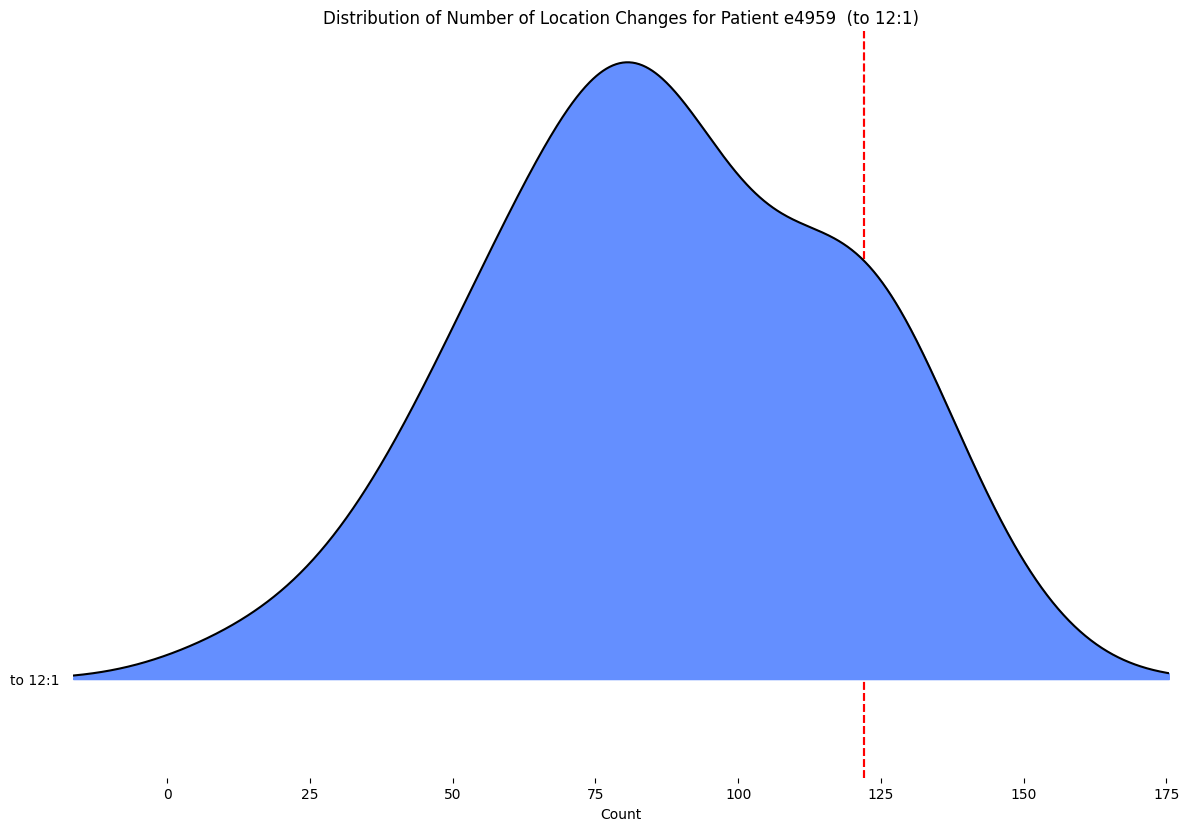

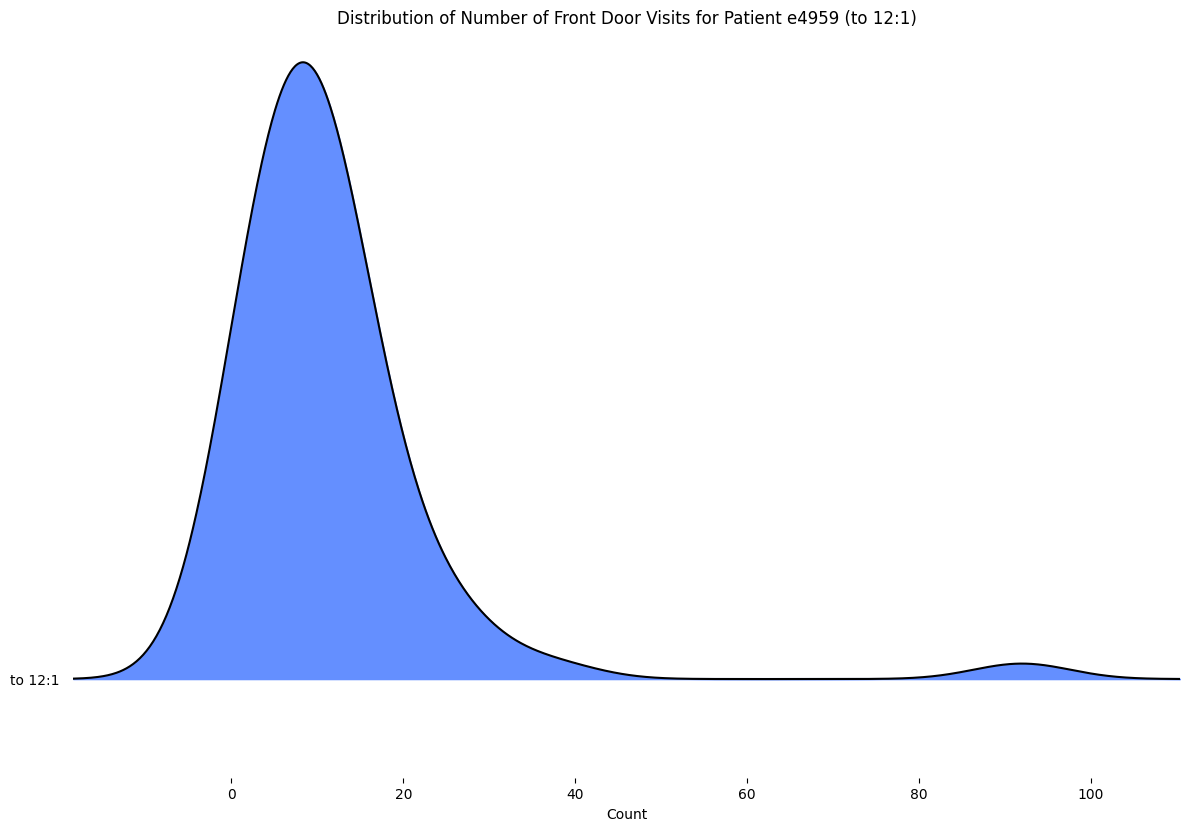

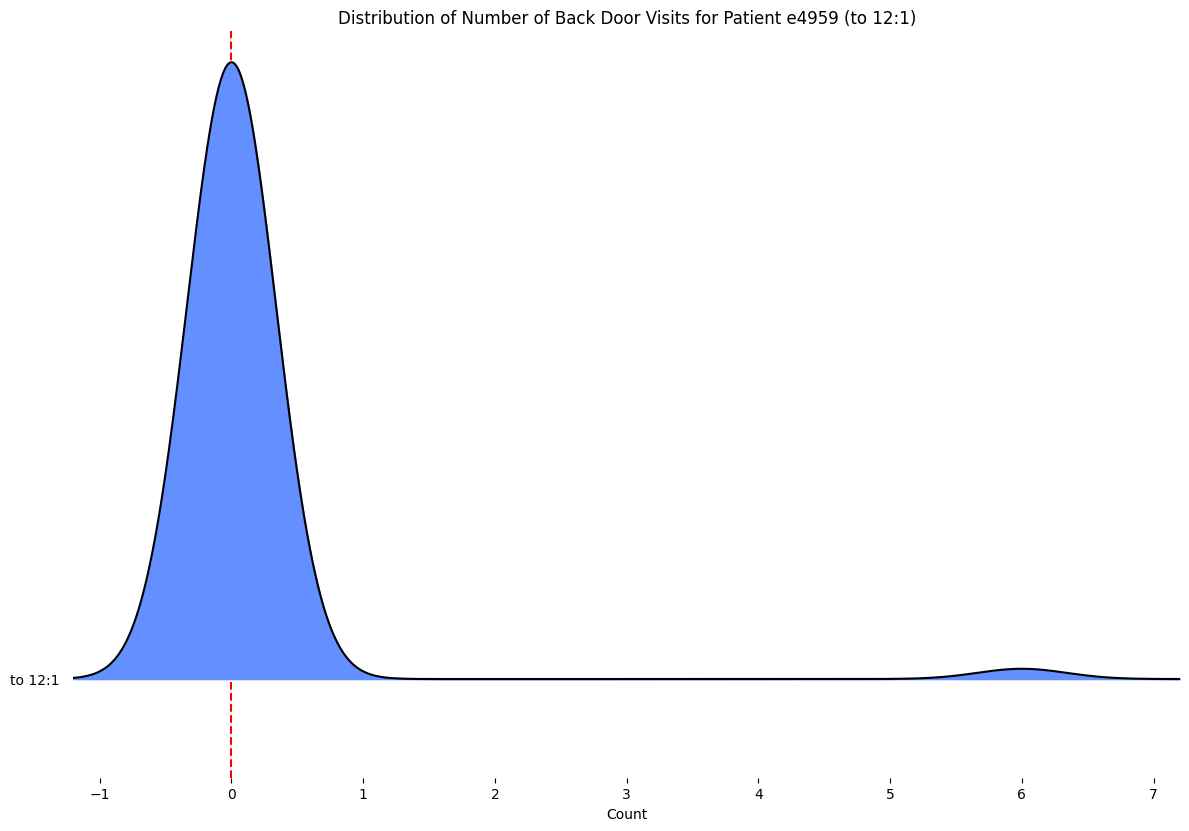

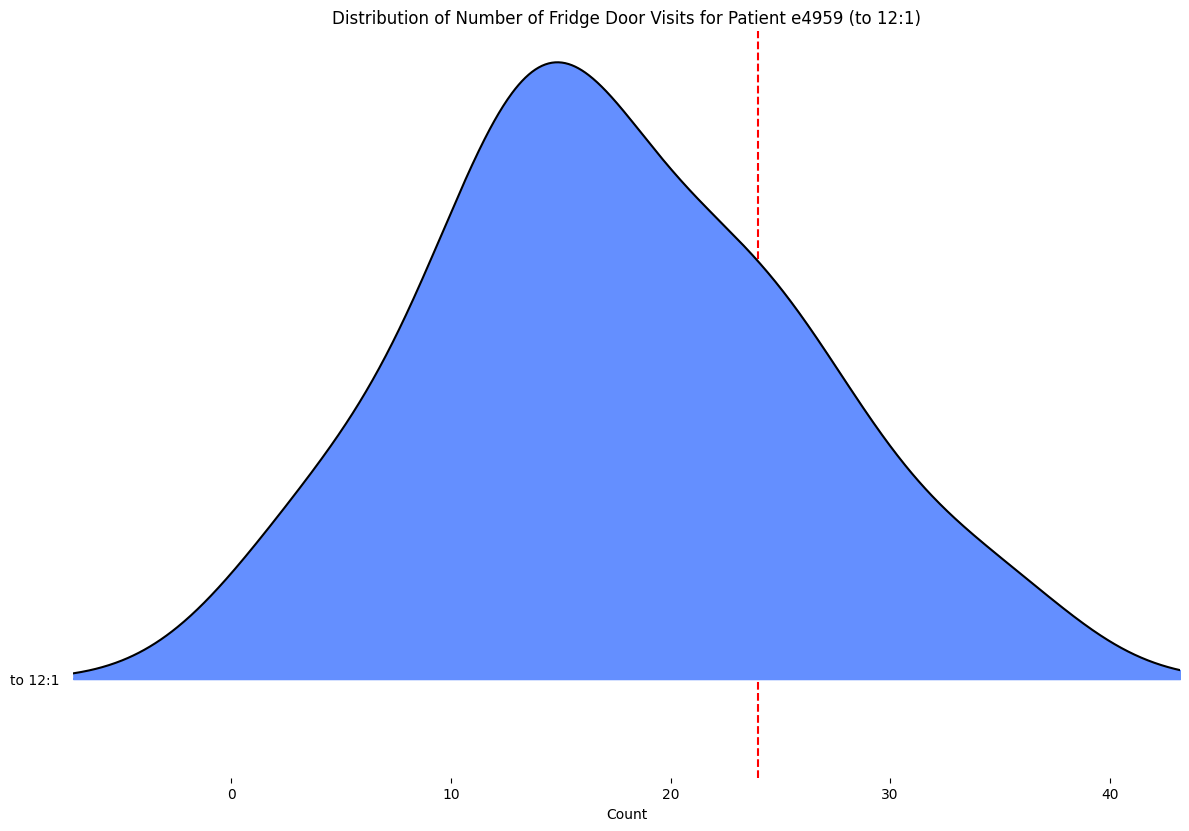

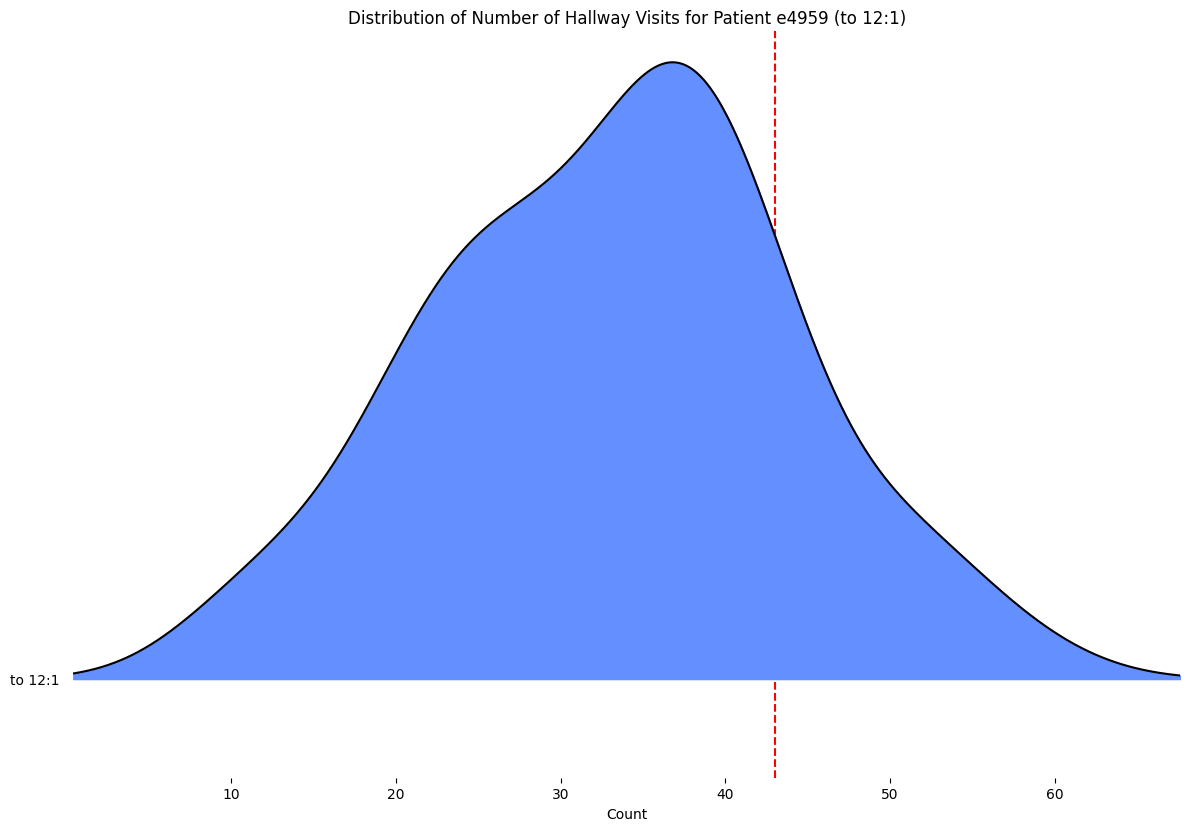

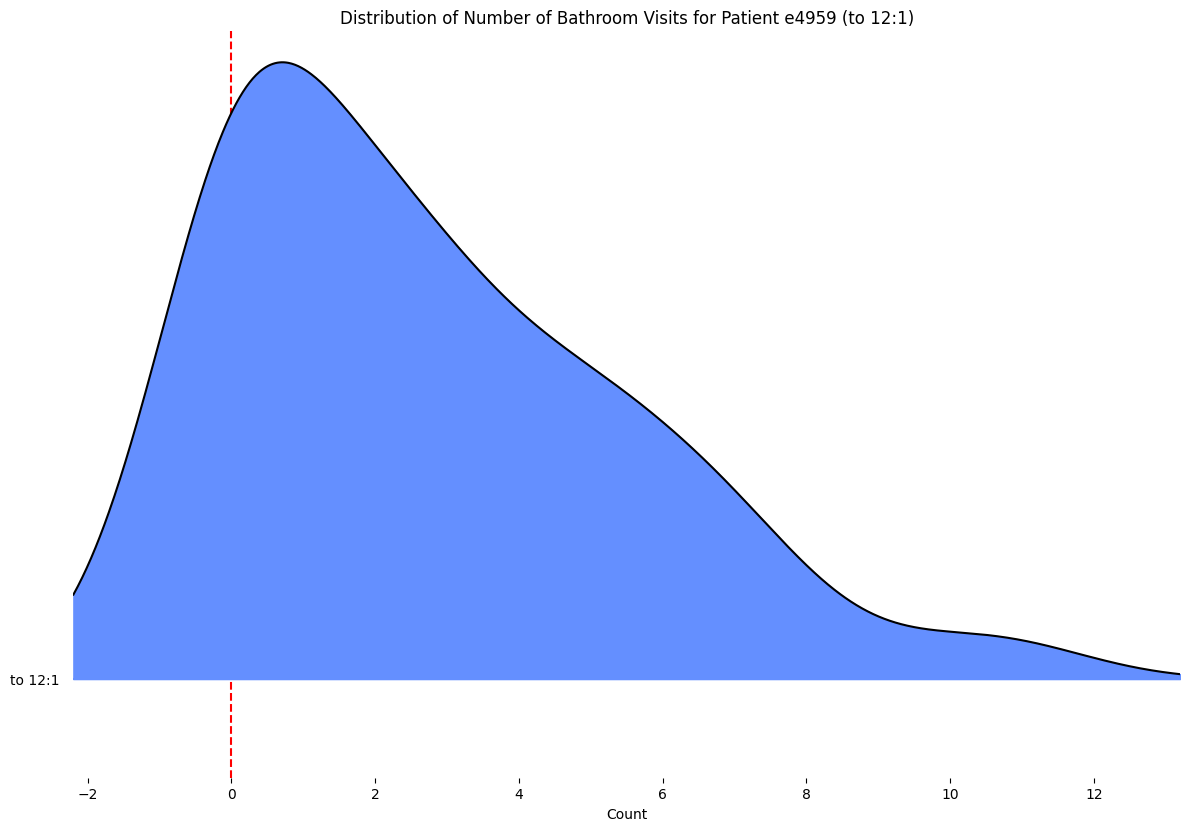

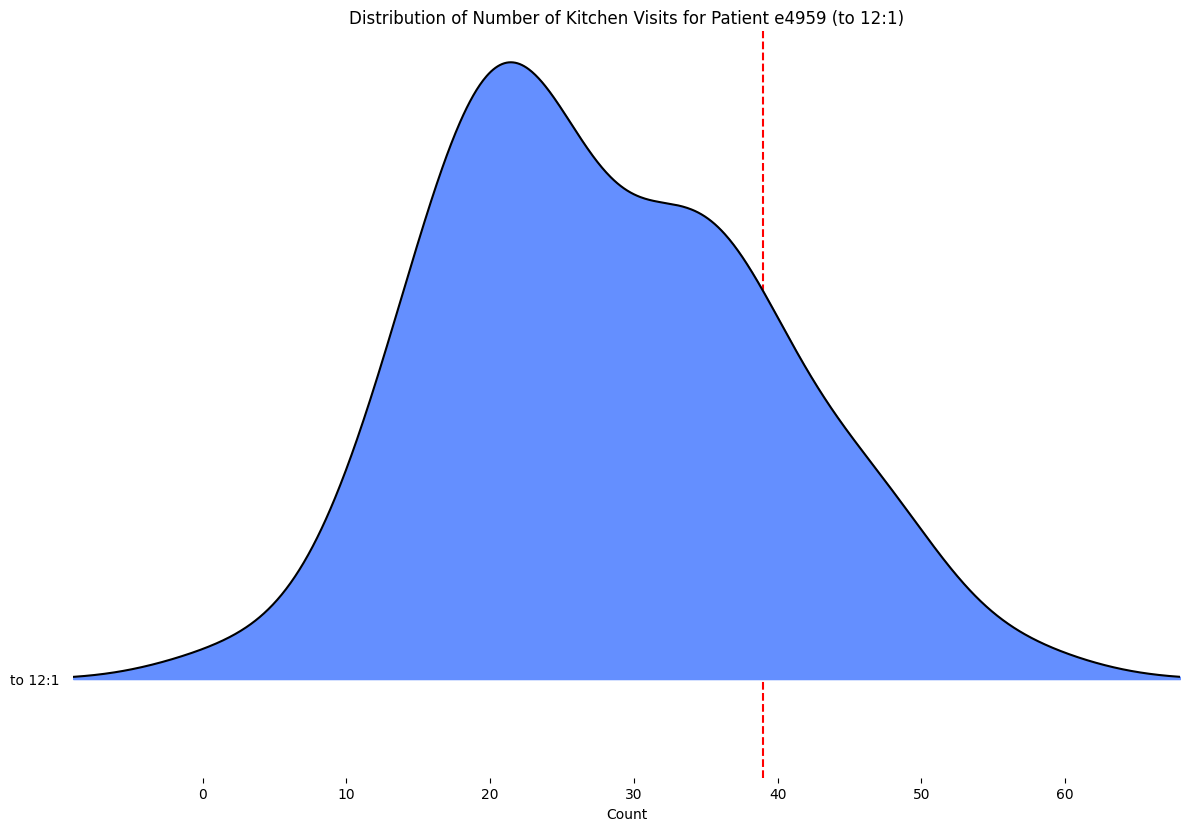

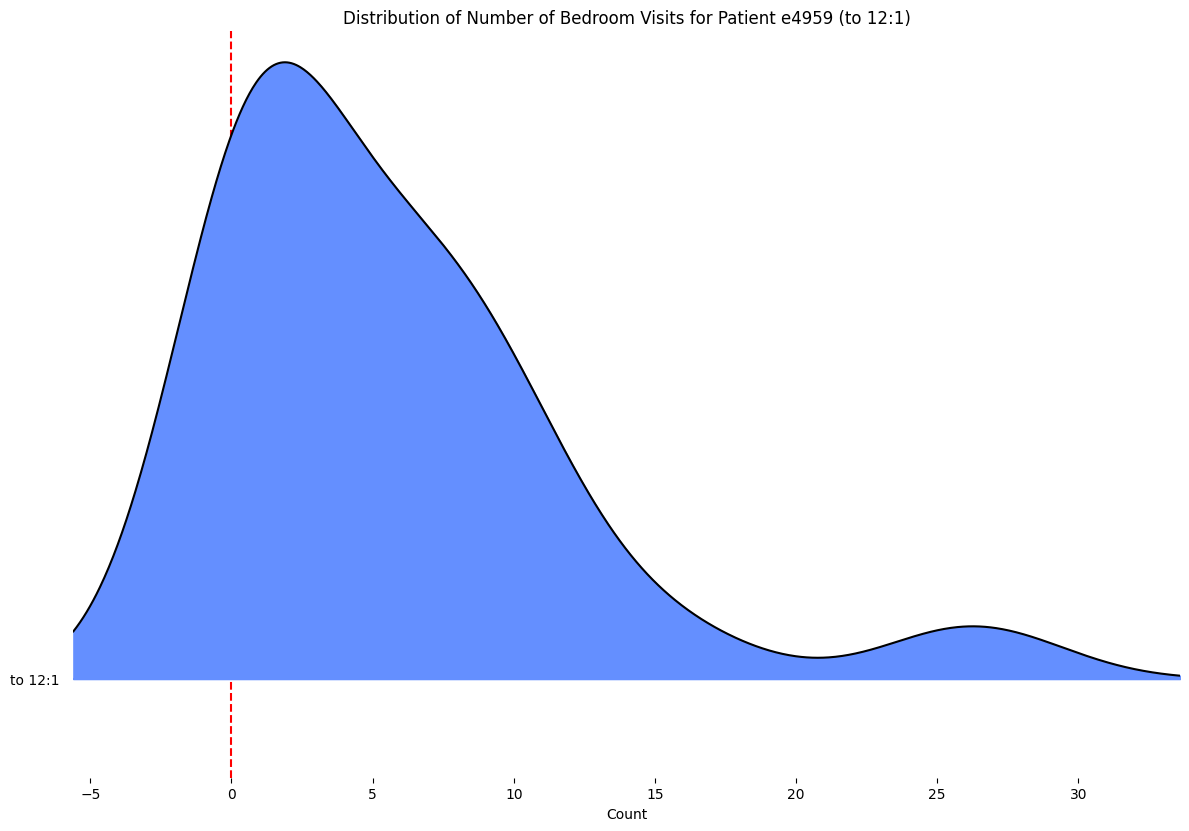

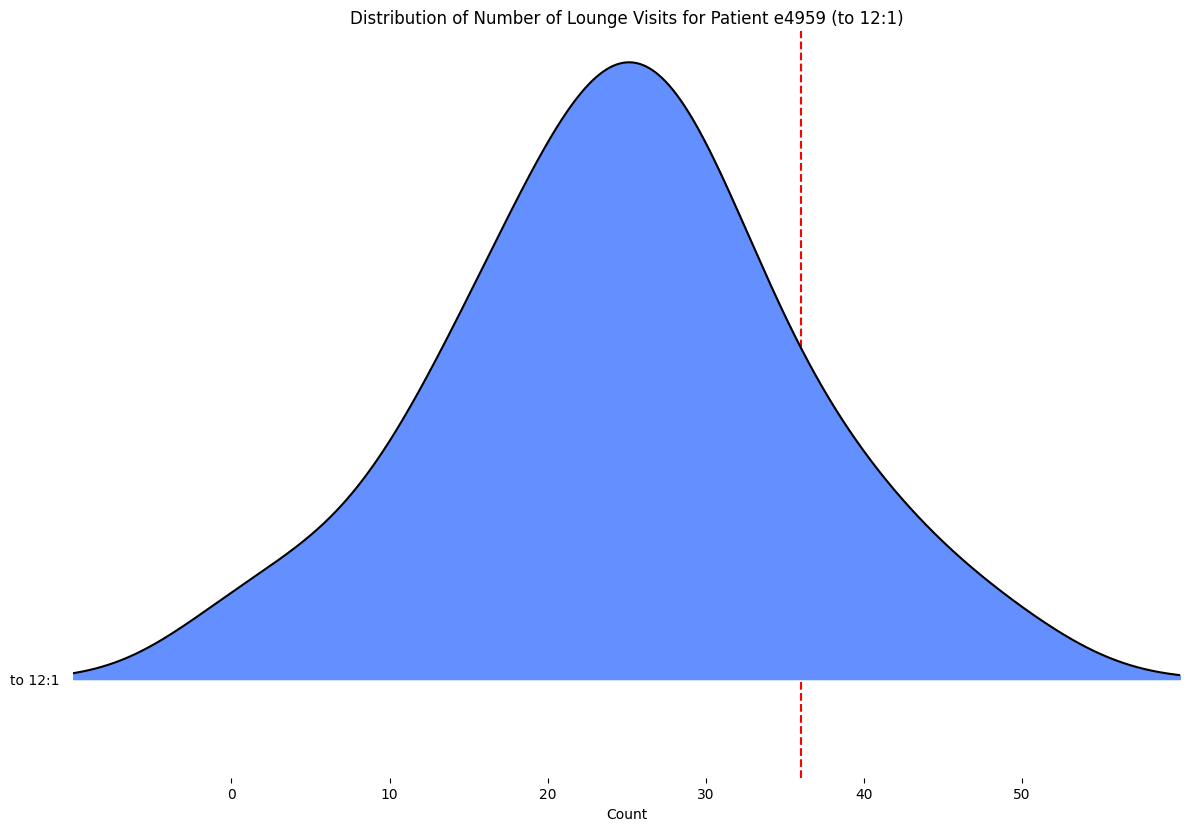

In [ ]:

var_ag_point = variation_count.loc[variation_count['Agitation']==ag_flag].reset_index(drop=False)
loc_ag = loc_count.loc[loc_count['Agitation']==ag_flag].reset_index(drop=False)
var_val = var_ag_point['match'].values[sample_n]
print(f' Interval: {dist_interval}')
print(f'variation: {var_val}')

for l in merge_df['location_name'].dropna().unique():
  print(f'{l}: {loc_ag[l].values[sample_n]}')

# Creating a joyplot grouped by hour
data = variation_count[['only_interval','match']].loc[(variation_count['Agitation']==0) & (variation_count['only_interval']==dist_interval)]
fig, axes = joyplot(
    data=data,
    by="only_interval",
    column='match',
    figsize=(12, 8)
)

plt.title(f'Distribution of Number of Location Changes for Patient {pid}  ({dist_interval})')

for ax in axes:
  ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
  ax.set_xlabel("Count", fontsize=10)  # Set a label for x-axis (optional)
  color_vertical = 'red' if ag_flag==1 else 'green'
  plt.axvline(x=var_val, color=color_vertical, linestyle='--', linewidth=1.5, label='Agitation Sample Value')
  #plt.legend()
# Show the plot
plt.show()

for l in merge_df['location_name'].dropna().unique():
  # Creating a joyplot grouped by hour
  data = loc_count[['only_interval',l]].loc[(loc_count['Agitation']==0) & (variation_count['only_interval']==dist_interval)]
  fig, axes = joyplot(
      data=data,
      by="only_interval",
      column=l,
      figsize=(12, 8)
  )

  for ax in axes:
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.set_xlabel("Count", fontsize=10)  # Set a label for x-axis (optional)
  color_vertical = 'red' if ag_flag==1 else 'green'
  plt.axvline(x=loc_ag[l].values[sample_n], color=color_vertical, linestyle='--', linewidth=1.5, label='Agitation Sample Value')

  plt.title(f'Distribution of Number of {l} Visits for Patient {pid} ({dist_interval})')
  # Show the plot
  plt.show()


,only_interval,match
1,to 12:0,110.0
5,to 12:0,138.0
9,to 12:0,119.0
13,to 12:0,134.0
17,to 12:0,95.0
...,...,...
251,to 12:0,124.0
255,to 12:0,141.0
259,to 12:0,103.0
263,to 12:0,105.0


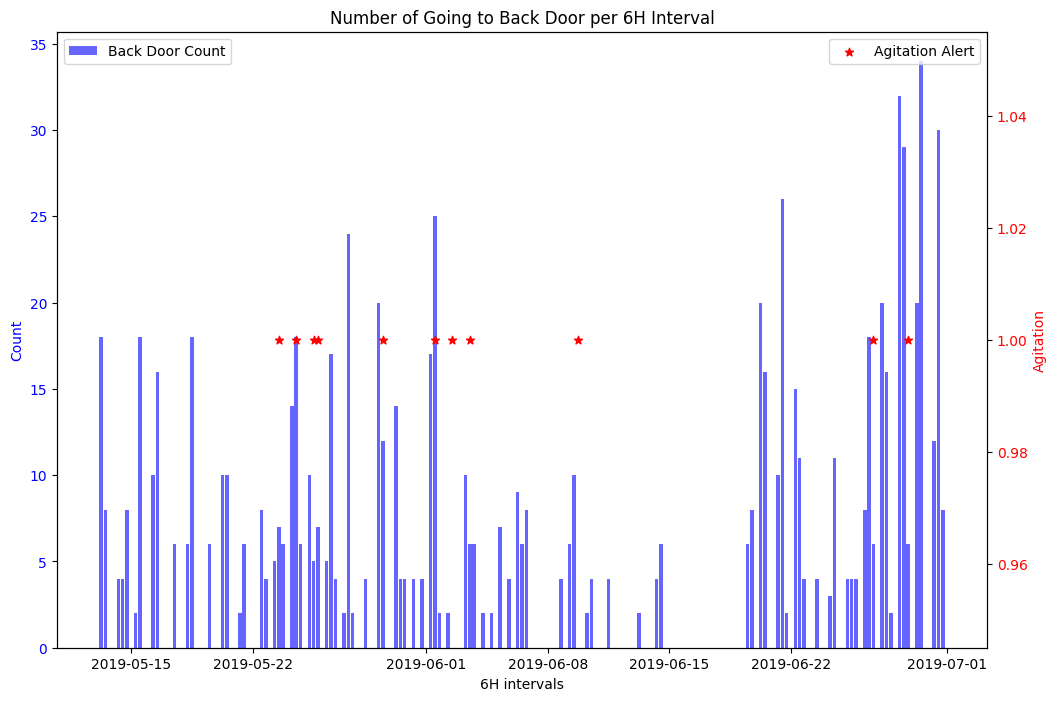

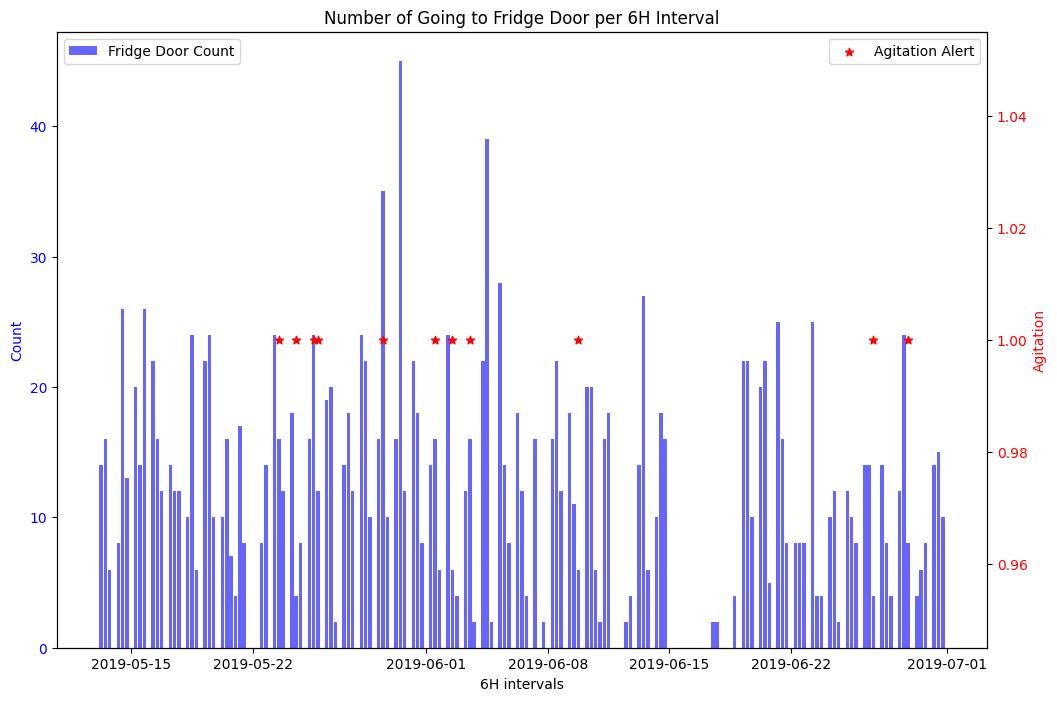

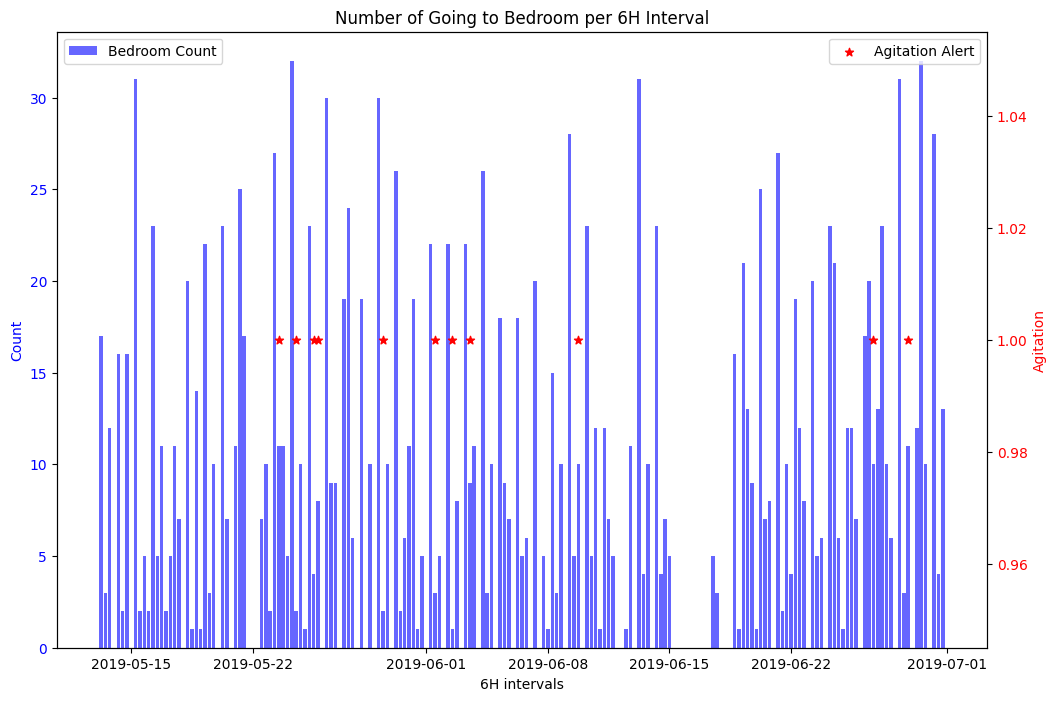

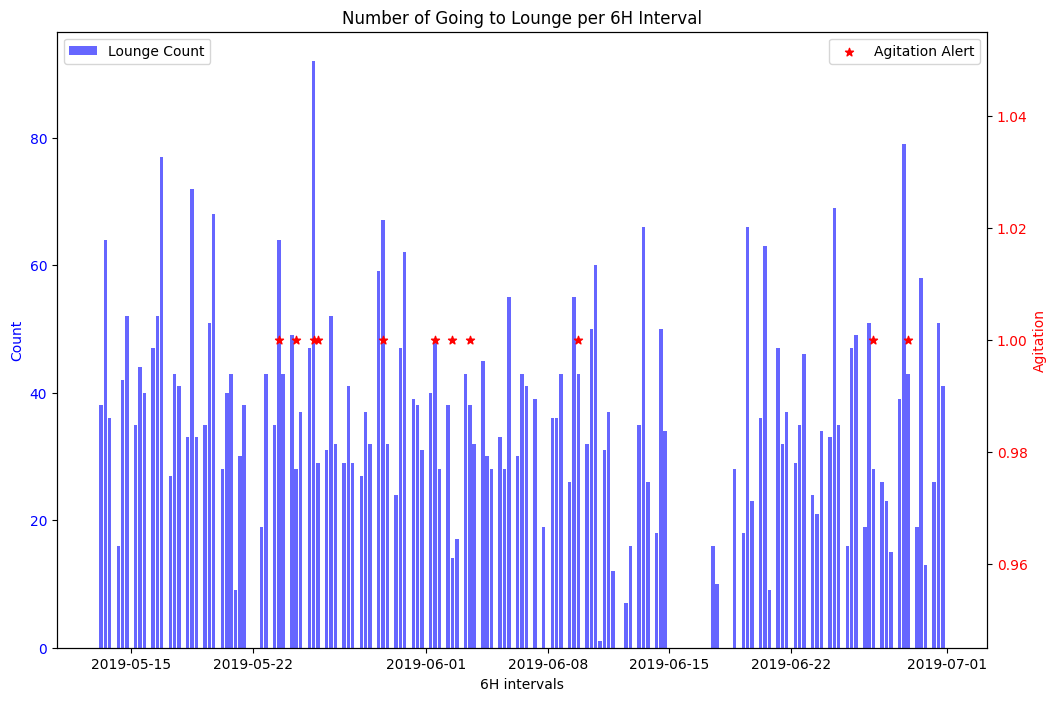

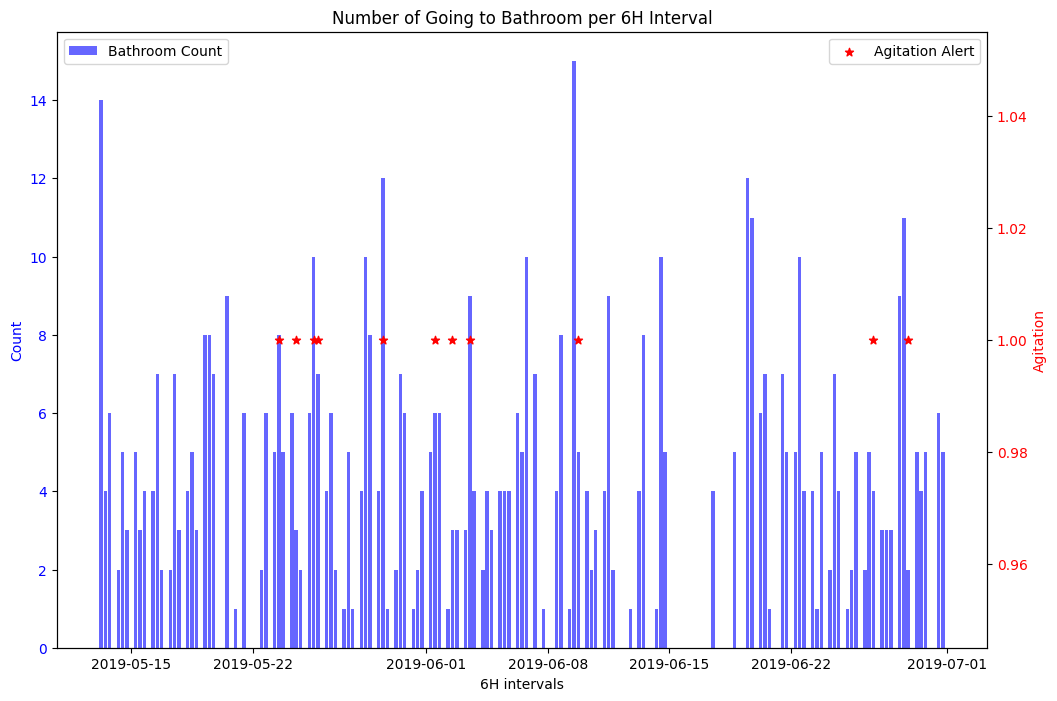

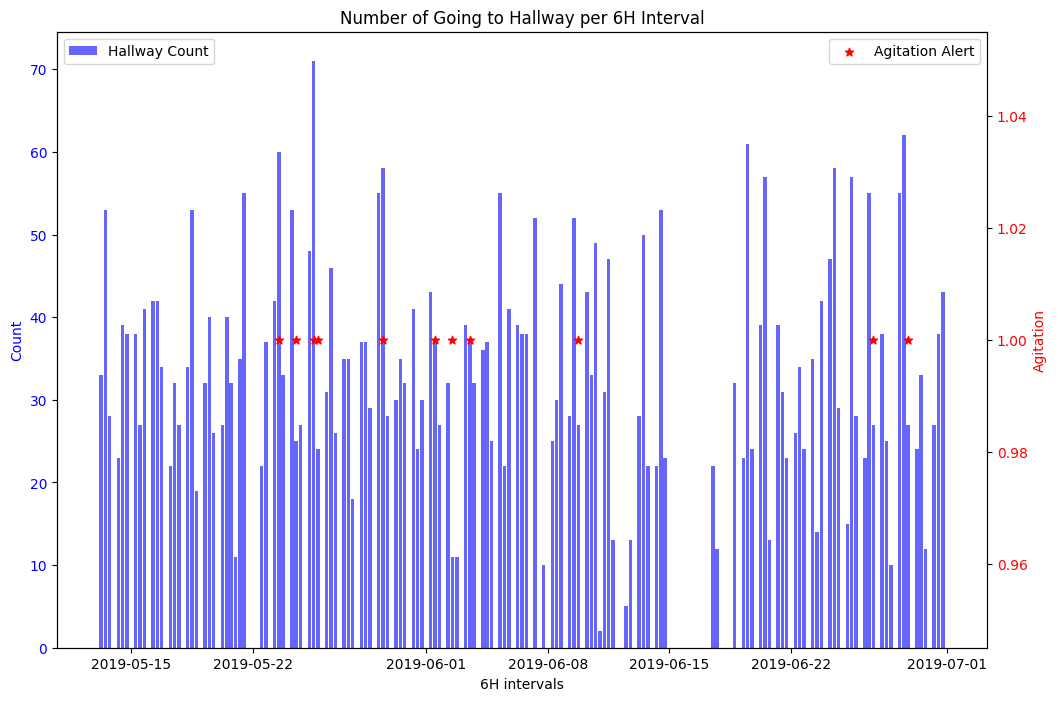

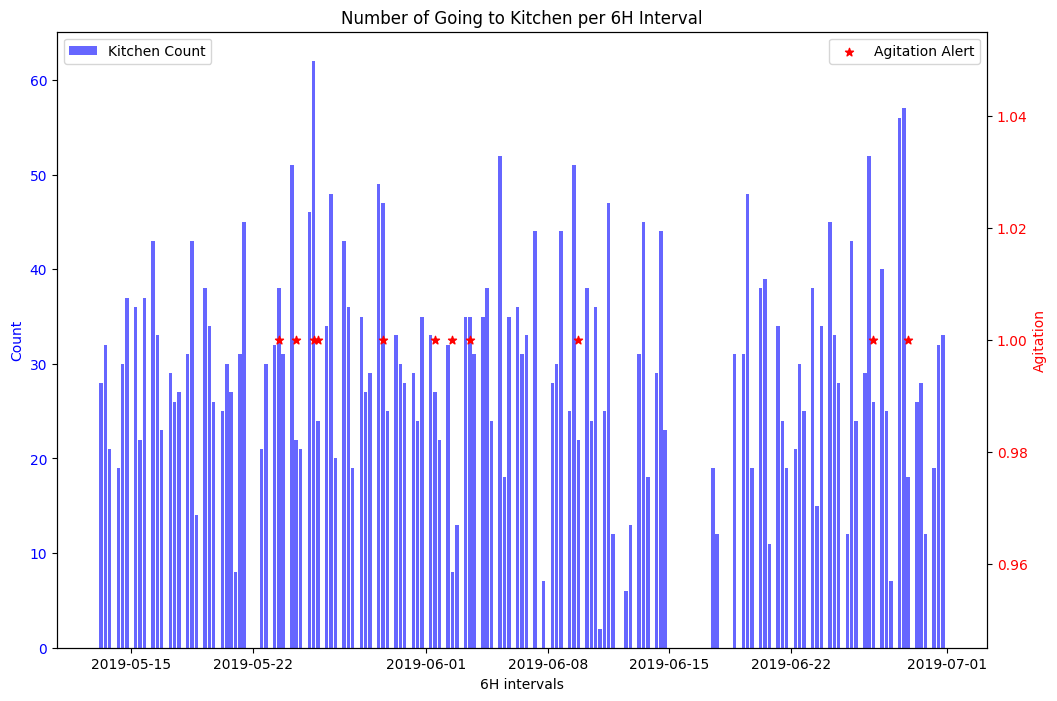

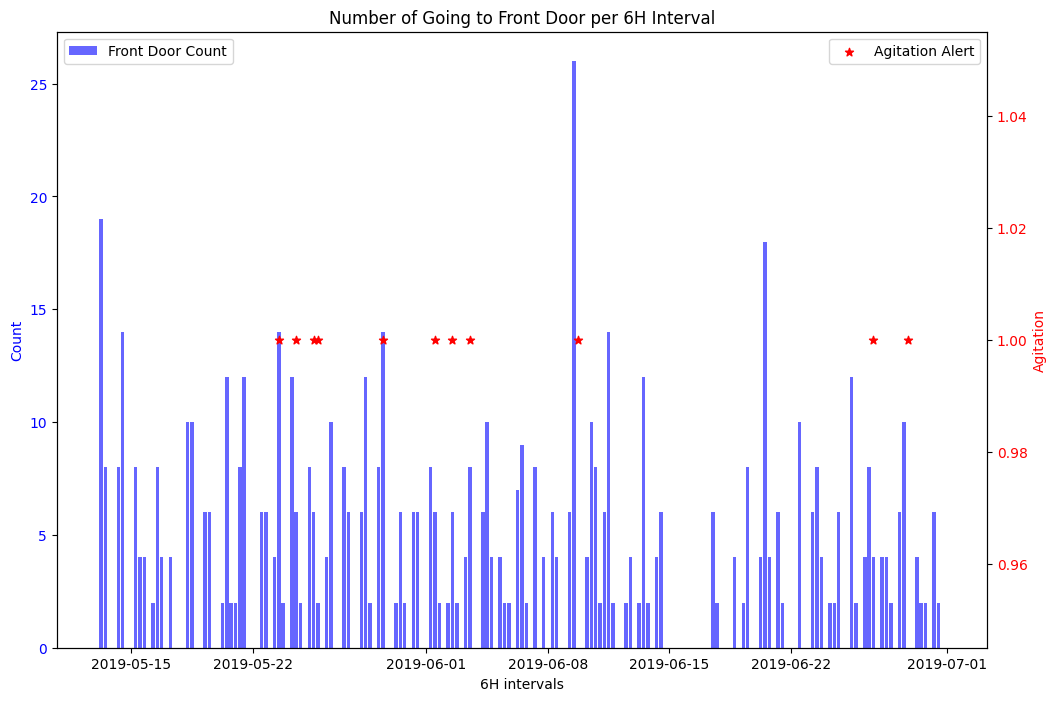

In [ ]:
import matplotlib.pyplot as plt

for l in merge_df['location_name'].unique():
    if l in loc_count.columns:
        # Create a new figure for each location
        fig, ax1 = plt.subplots(figsize=(12, 8))

        # Plot the bar chart for counts (on the left y-axis)
        ax1.bar(loc_count[f'{interval}H_interval'], loc_count[l], width=0.2, color='b', alpha=0.6, label=f'{l} Count')

        # Labeling the left axis
        ax1.set_xlabel(f'{interval}H intervals')
        ax1.set_ylabel('Count', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Create a twin axis to plot agitation values (on the right y-axis)
        ax2 = ax1.twinx()

        # Highlight the points where the agitation alert (match > 0) occurs
        ax2.scatter(merge_df[f'{interval}H_interval'][merge_df['Agitation'] > 0],
                    merge_df['Agitation'][merge_df['Agitation'] > 0],
                    color='red', marker='*', zorder=60, label='Agitation Alert')

        # Labeling the right axis
        ax2.set_ylabel('Agitation', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

        # Title and legend
        plt.title(f'Number of Going to {l} per {interval}H Interval')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Show the plot
        plt.show()


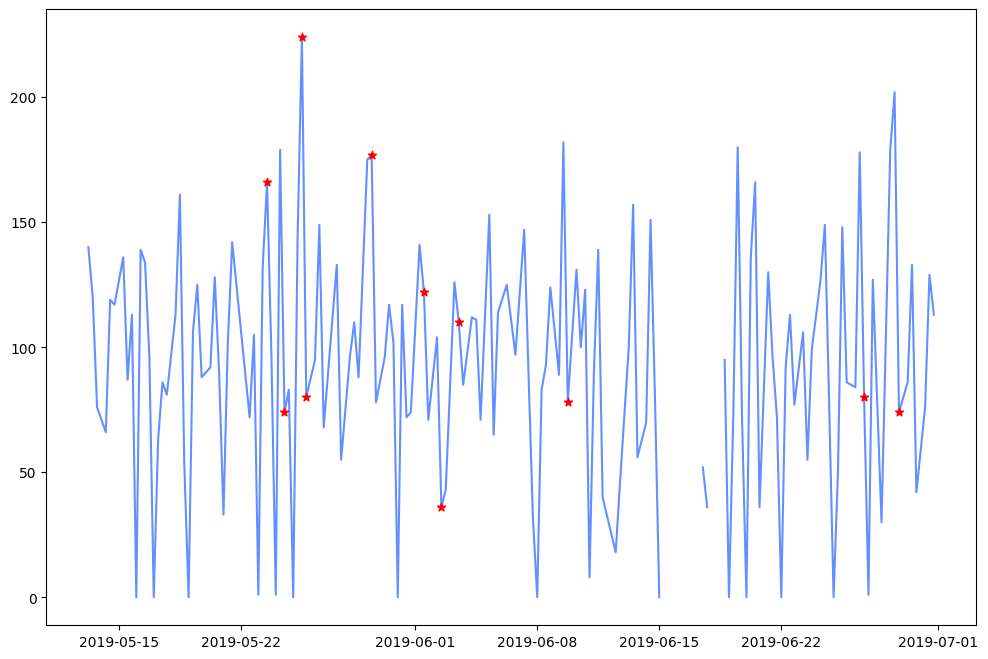

In [ ]:
ag_var = pd.merge(variation_count,agitation_count,how='outer').set_index(f'{interval}H_interval')
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ag_var.index,ag_var['match'])

# Highlight the points where the agitation alert (match == True) occurs
ax.scatter(ag_var.index[ag_var['Agitation'] >0],
           ag_var['match'][ag_var['Agitation'] >0],
           color='red', marker='*', zorder=5, label='Alert')

<DatetimeArray>
['2019-05-23 12:01:46', '2019-05-24 12:02:08', '2019-05-25 12:01:29',
 '2019-05-25 18:01:19', '2019-05-29 12:01:57', '2019-06-01 12:01:58',
 '2019-06-02 12:02:19', '2019-06-03 12:01:57', '2019-06-09 18:01:39',
 '2019-06-26 18:01:28', '2019-06-28 18:02:11']
Length: 11, dtype: datetime64[ns]
50
43
57
34
27
5
9
4


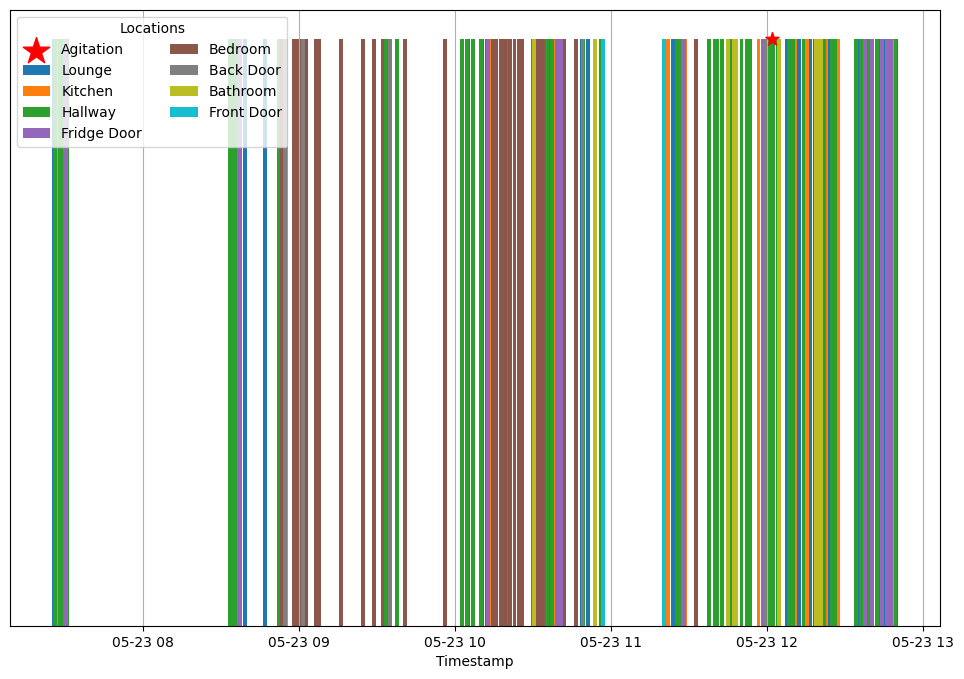

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta

# Assuming merge_df and df are already defined

# Get the unique dates when Agitation is greater than 0 and not NaN
ag_time = merge_df['timestamp'].loc[(merge_df['Agitation'] > 0) & (~merge_df['Agitation'].isna())].unique()
print(ag_time)

# Set the start and end times based on the first ag_date
start_ts = ag_time[0] - timedelta(hours=9)
end_ts = ag_time[0] + timedelta(hours=1)

# Remove rows where 'location_name' is NaN
df_clean = merge_df.dropna(subset=['location_name'])
df_clean = df_clean.loc[df_clean['timestamp'].between(start_ts, end_ts)]

# Second figure (timeline with location bars)
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Timeline plot
unique_locations = df_clean['location_name'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_locations))  # You can change 'tab10' to another colormap

# Plot each location with a colored bar
for idx, l in enumerate(unique_locations):
    if not pd.isna(l):  # Check if location name is not NaN
        #location_data = df_clean['location_name'].loc[df_clean['location_name'] == l]
        # Create vertical bars for each location along the timestamp
        timestamp = df_clean['timestamp'].loc[df_clean['location_name'] == l]
        ax2.bar(timestamp, np.ones(len(timestamp)), width=0.001, color=colors(idx), label=l)
        print(len(timestamp))
# Plot agitation points as scatter plot
agitation_df = merge_df.loc[merge_df['Agitation'] == 1].copy()
agitation_df = agitation_df.loc[agitation_df['timestamp'].between(start_ts, end_ts)]

ax2.scatter(agitation_df['timestamp'], np.ones(agitation_df['timestamp'].shape[0]),
        marker='*', color='r', s=100, label='Agitation', zorder=5)  # Adjust size for visibility


# Add the legend manually using the handles and labels
ax2.legend(loc='upper left', title='Locations', ncol=2, markerscale=2)

# Set labels and grid
ax2.set_xlabel('Timestamp')
ax2.set_yticks([])  # Remove y-ticks for agitation points
ax2.grid(True)

# Adjust layout for the second figure

# Show the figure
plt.show()


In [ ]:
l

'Front Door'

In [ ]:
unique_locations

['Lounge', 'Hallway', 'Kitchen', 'Fridge Door', 'Front Door', 'Bathroom', 'Bedroom', 'Back Door', NaN]
Categories (8, object): ['Back Door', 'Bathroom', 'Bedroom', 'Fridge Door', 'Front Door', 'Hallway',
                         'Kitchen', 'Lounge']

In [ ]:
agitation_df

,timestamp,date,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Systolic blood pressure,Total body water,location_name,type,Agitation
4461,2019-05-23 12:01:46,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agitation,1.0


In [ ]:
ag_date

numpy.datetime64('2019-05-23T00:00:00.000000000')